In [34]:
import pickle
from kid_readout.analysis import iqnoise, noise_fit

In [35]:
with open('/data/readout/pkl/2015-07-06_164951_compressor_noise_0.120_K.pkl') as f:
    pkls = pickle.load(f)

In [36]:
[p.noise_measurement_freq_MHz for p in pkls]

[96.103271484375,
 101.98583984375,
 108.904296875,
 112.294677734375,
 117.329345703125,
 127.833984375,
 195.724365234375,
 188.89990234375,
 184.53173828125,
 178.989013671875,
 174.94384765625,
 165.46337890625,
 164.40625,
 164.1171875,
 148.29931640625,
 144.18310546875,
 96.103271484375,
 101.98583984375,
 108.904296875,
 112.294677734375,
 117.329345703125,
 127.833984375,
 195.724365234375,
 188.89990234375,
 184.53173828125,
 178.989013671875,
 174.94384765625,
 165.46337890625,
 164.40625,
 164.1171875,
 148.29931640625,
 144.18310546875]

In [37]:
ch8off = pkls[16 + 13]
ch8off.noise_measurement_freq_MHz

164.1171875

In [38]:
single = ch8off # pkls[16 + 5]
single.noise_measurement_freq_MHz

164.1171875

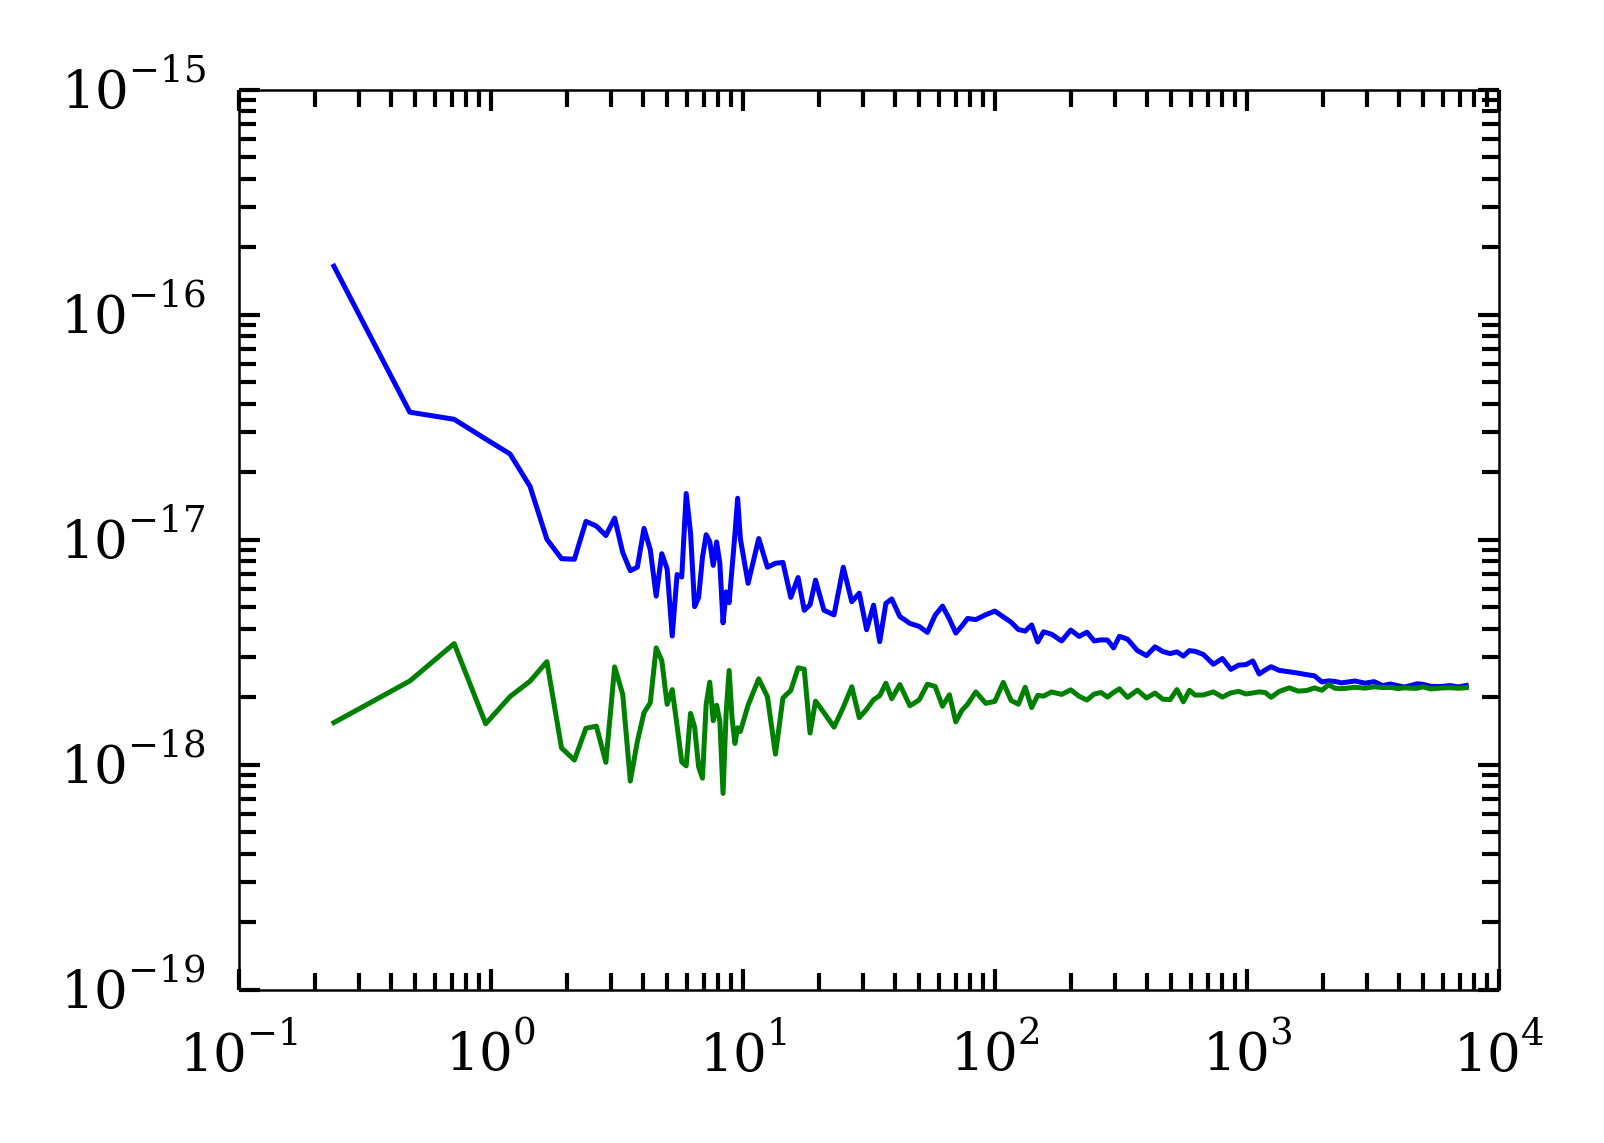

In [39]:
fig, ax = plt.subplots()
ax.loglog(single.pca_freq, single.pca_eigvals[1])
ax.loglog(single.pca_freq, single.pca_eigvals[0])
#ax.set_ylim(1e-18, 1e-16);

In [40]:
t = np.arange(single.fractional_fluctuation_timeseries.size) / single.timeseries_sample_rate
x_poly = np.polyfit(t, single.fractional_fluctuation_timeseries, 2)
detrended = single.fractional_fluctuation_timeseries - np.polyval(x_poly, t)

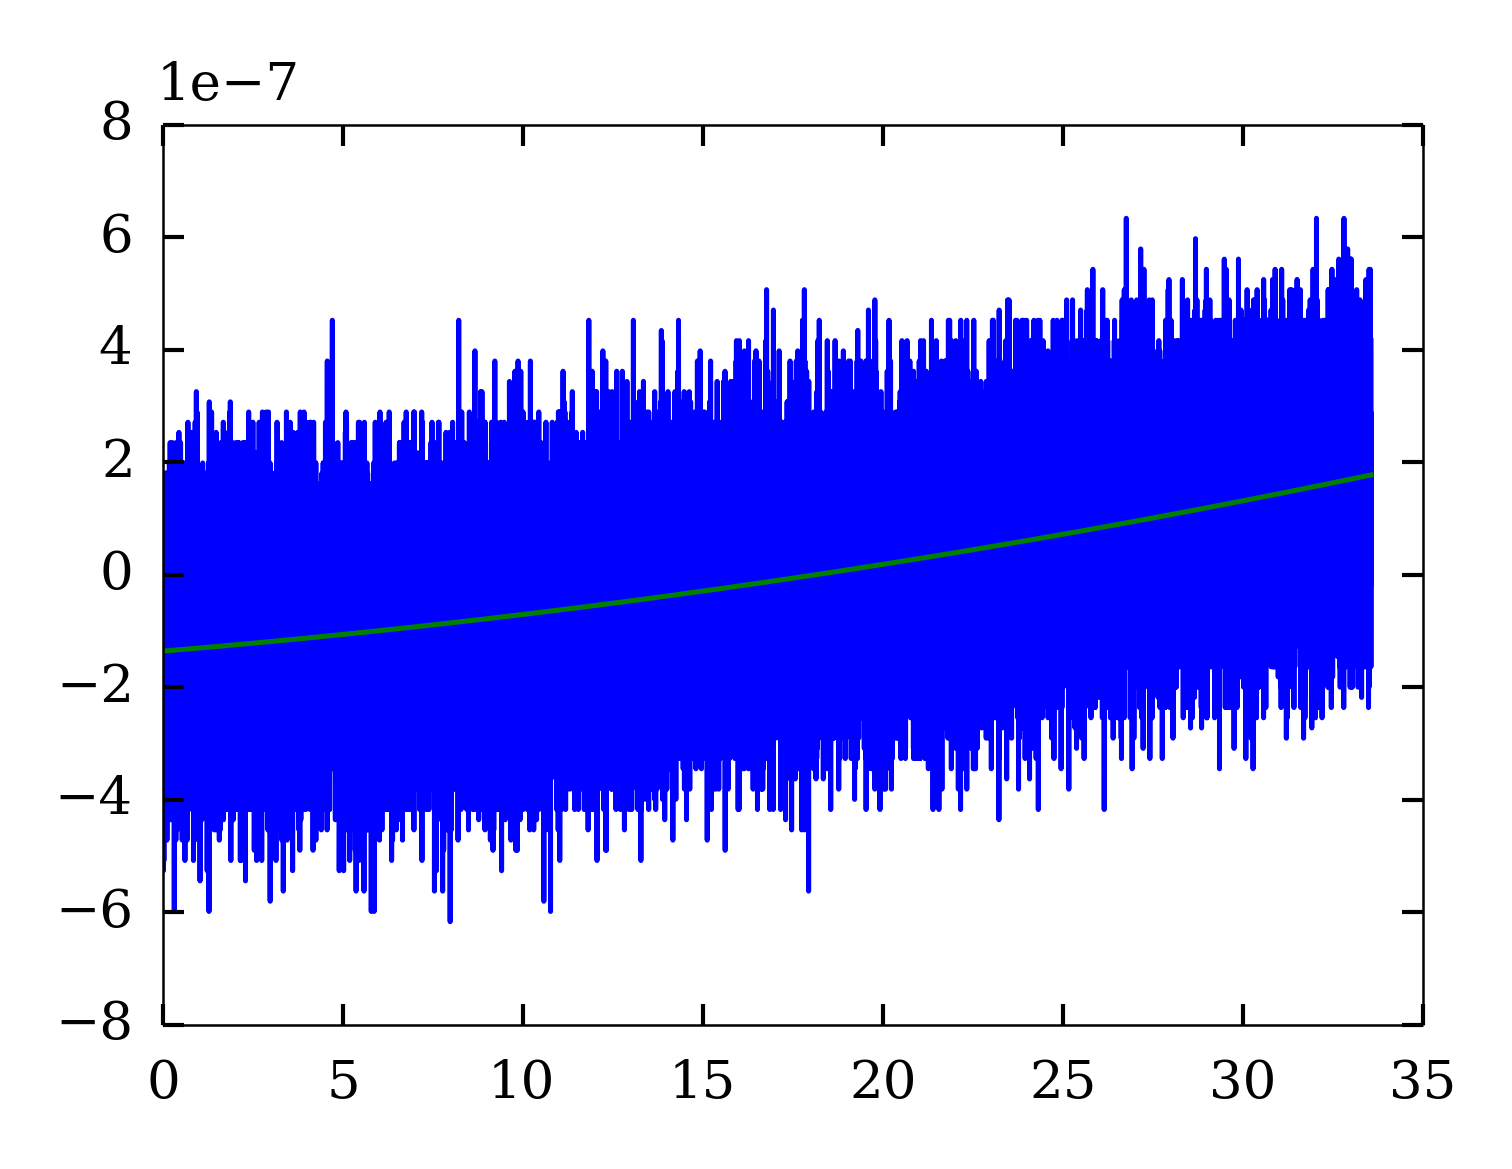

In [41]:
downsample = 10
fig, ax = plt.subplots()
ax.plot(t[::downsample], single.fractional_fluctuation_timeseries[::downsample])
ax.plot(t[::downsample], np.polyval(x_poly, t[::downsample]))

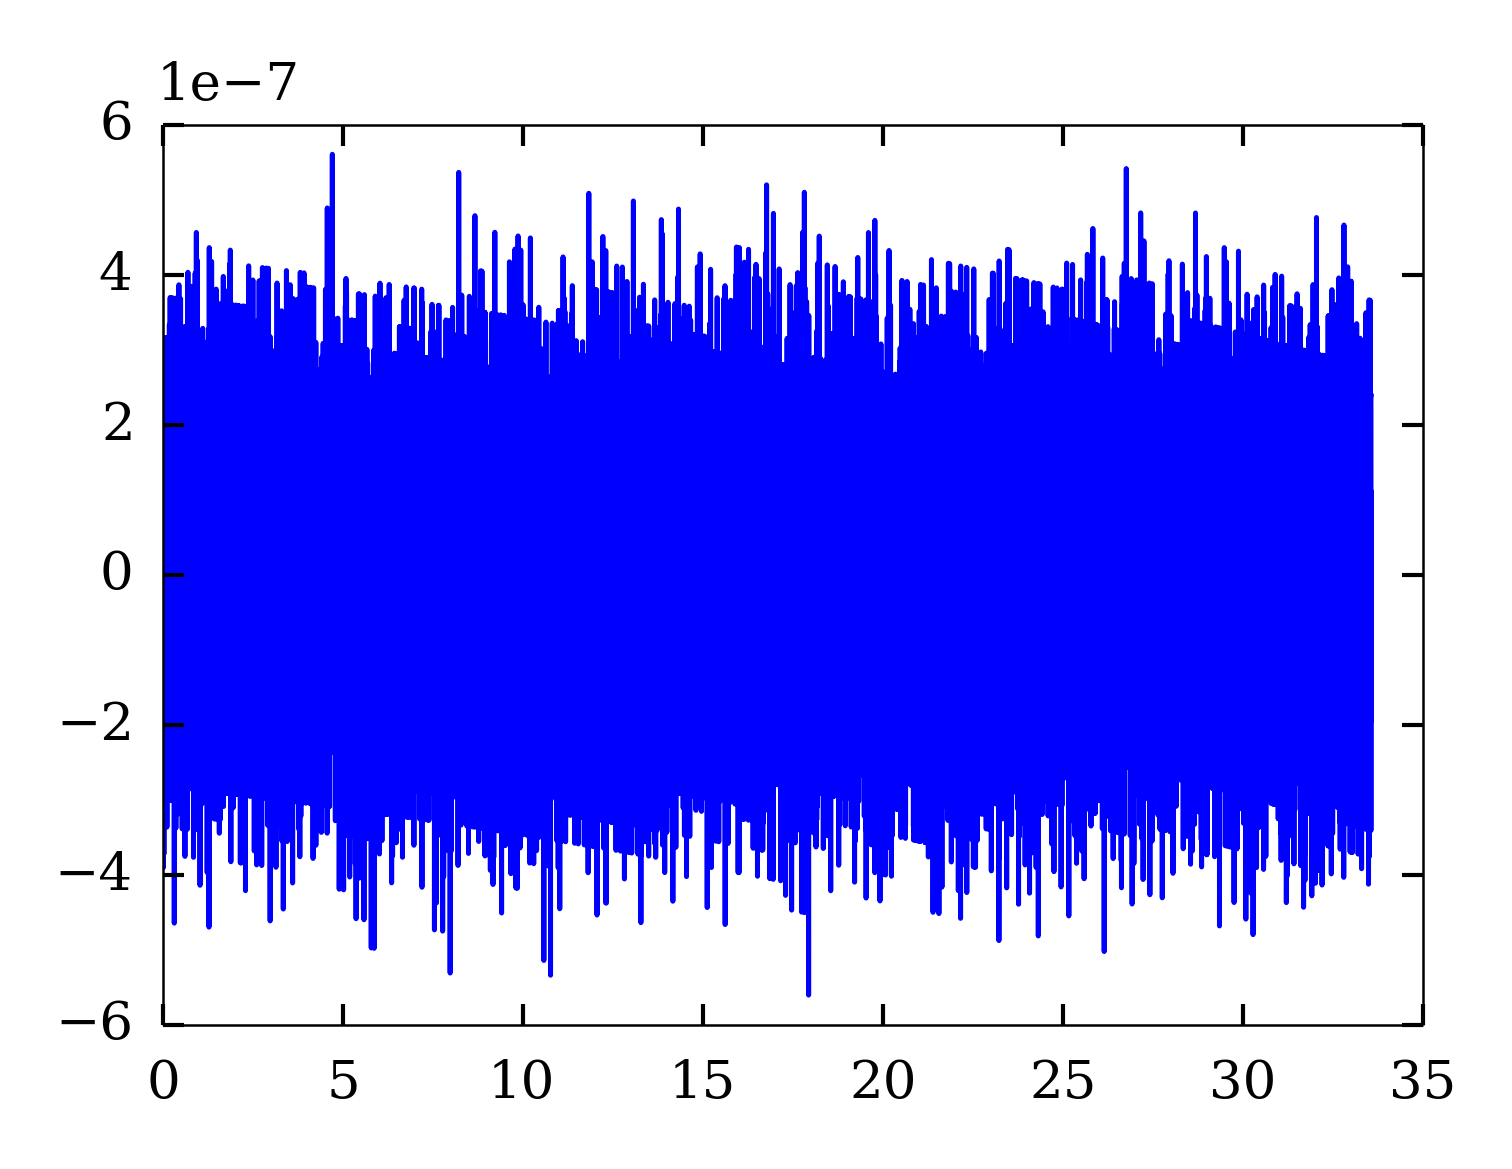

In [42]:
downsample = 10
fig, ax = plt.subplots()
ax.plot(t[::downsample], detrended[::downsample])

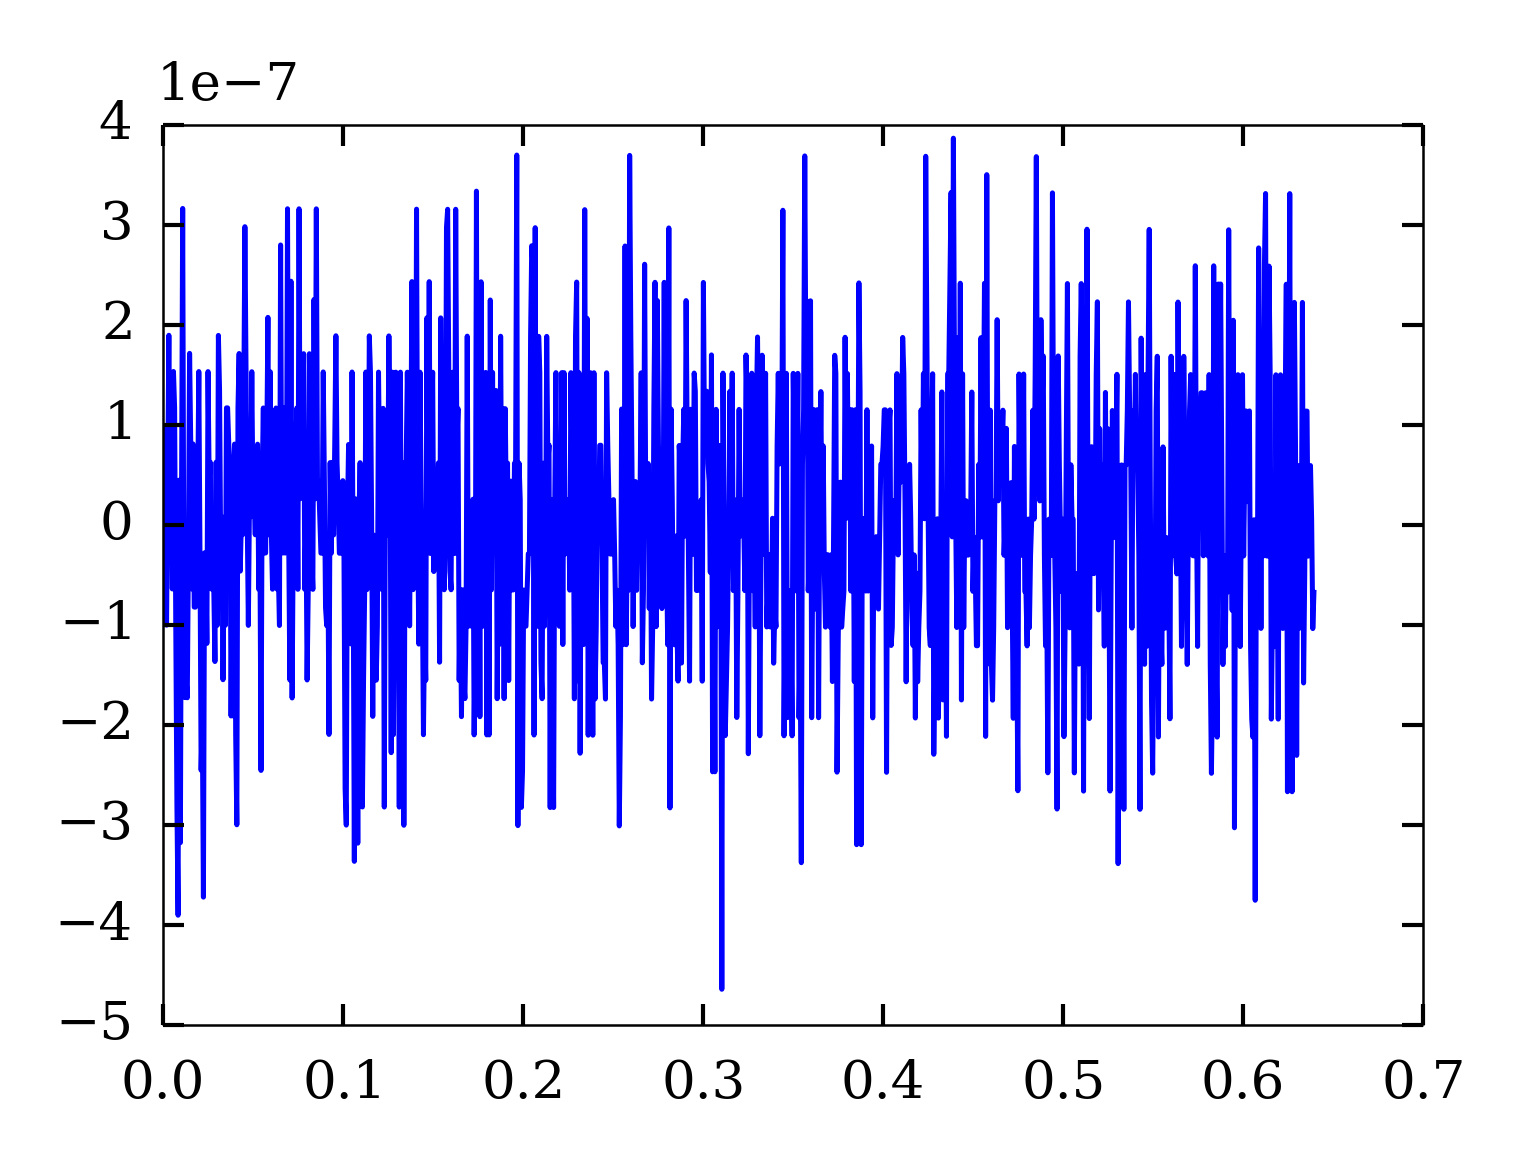

In [43]:
fig, ax = plt.subplots()
ax.plot(t[:1e4:downsample], detrended[:1e4:downsample])

In [44]:
fr,S,evals,evects,angles,piq = iqnoise.pca_noise(detrended, NFFT=None,
                                                 Fs=single.timeseries_sample_rate,
                                                 use_log_bins=False)

using NFFT: 2** 16.0


In [45]:
detrended.size / fr.size

15.999511733650706

Why not 16?

In [46]:
nf = noise_fit.fit_single_pole_noise(fr, evals[1], max_num_masked=8)

In [102]:
evals[0][:10]

array([  1.63442237e-19,   1.22305805e-18,   2.21863357e-18,
         3.05473945e-18,   1.42125656e-18,   1.82373901e-18,
         2.24509686e-18,   2.90213641e-18,   1.20140408e-18,
         9.62629095e-19])

In [98]:
evals[1][0]

4.19156598060967e-18

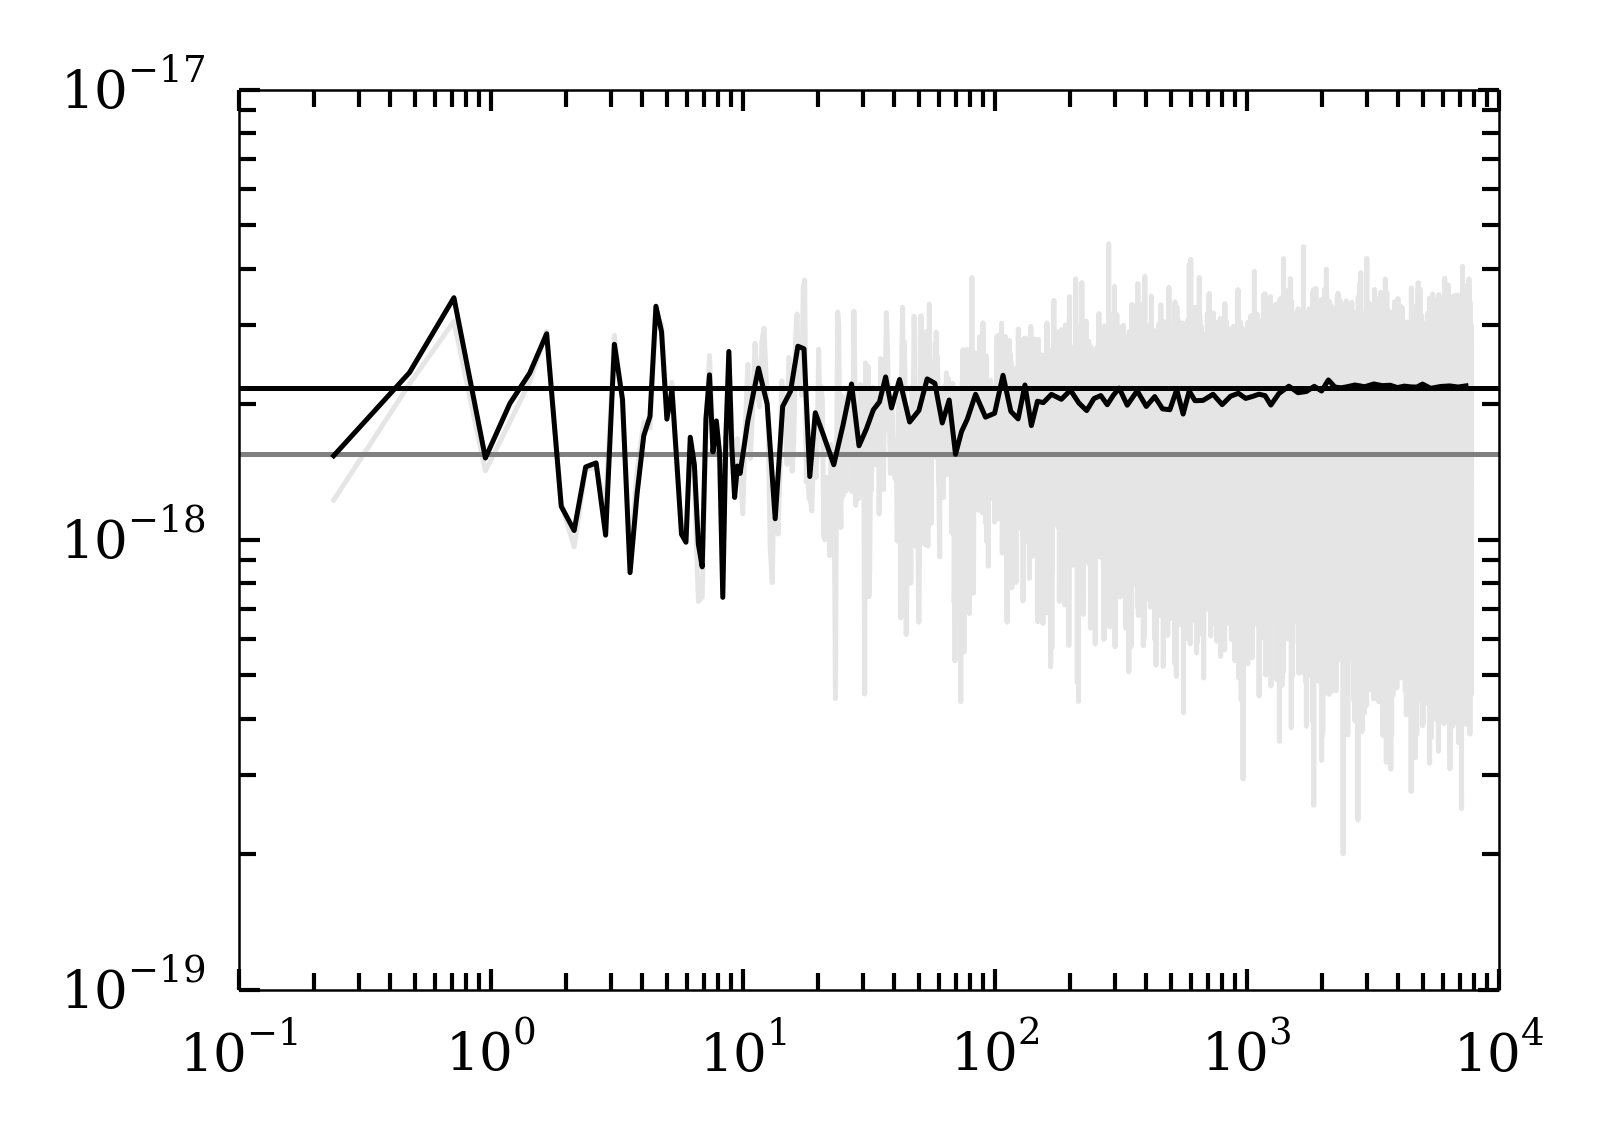

In [84]:
fig, ax = plt.subplots()
ax.loglog(fr, evals[0], 'gray', alpha=0.2)
ax.axhline(np.mean(evals[0][fr > 1e3]), color='gray', linestyle='-')

ax.loglog(single.pca_freq, single.pca_eigvals[0], '-k')
ax.axhline(np.mean(single.pca_eigvals[0][single.pca_freq > 1e3]), color='black', linestyle='-')

#ax.loglog(single.pca_freq, single.pca_eigvals[1], '-g')
#ax.loglog(fr, evals[1], 'blue', alpha=0.2)



In [123]:
single.pca_freq[-2:]

array([ 6911.99302673,  7423.99692535])

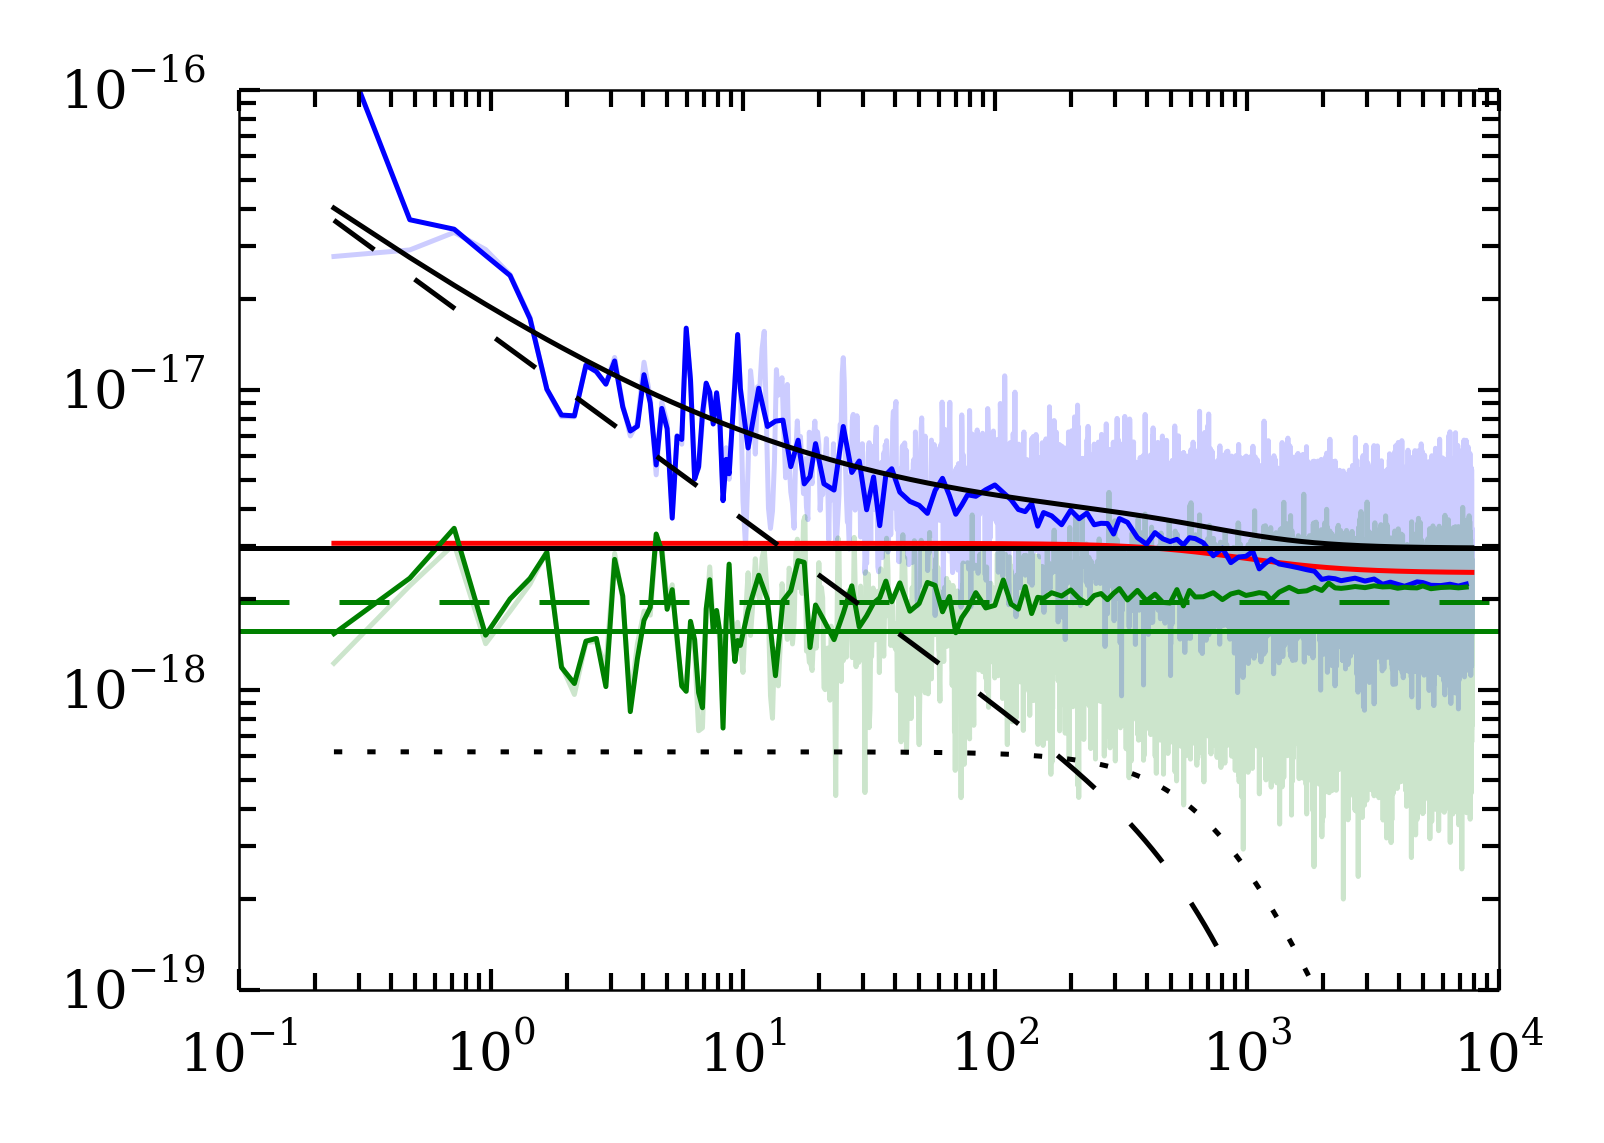

In [125]:
fig, ax = plt.subplots()
ax.plot(fr, evals[1], 'b', alpha=0.2)
ax.plot(fr, evals[0], 'g', alpha=0.2)
ax.axhline(np.mean(evals[0][1:]), color='g')
#ax.plot(fr, nf.A / (1 + (fr / nf.fc)**2) + nf.nw, '-k')
#S1Hz = 1.0e-17
#A_scale = 0.7
#ax.plot(fr, (S1Hz * fr**(-1/2) + A_scale * nf.A) / (1 + (fr / nf.fc)**2) + nf.nw, '-r')
ax.plot(fr, nf.A / (1 + (fr / nf.fc)**2) + nf.nw, '-r')
ax.plot(single.pca_freq, single.pca_eigvals[1], '-b')
ax.plot(single.pca_freq, single.pca_eigvals[0], '-g')
ax.axhline(np.mean(single.pca_eigvals[0][1:]), linestyle='--', color='g')


f_knee = 182.582888  # +/- 119.0965 (65.23%) (init= 0.1)
white = 6.1996e-19  # +/- 1.34e-19 (21.57%) (init= 3.049867e-18)
alpha = 0.61442762  # +/- 0.047049 (7.66%) (init= 2)
invtau = 822.036998  # +/- 82.27016 (10.01%) (init= 500)
amp = 2.9596e-18  # +/- 6.55e-21 (0.22%) (init= 3.049867e-18)
model= white * (1. + (f_knee / fr)**alpha) / (1 + (fr / invtau)**2) + amp  # 0.8 * amp looks much better
ax.plot(fr, model, '-k')
ax.plot(fr, white / (1 + (fr / invtau)**2), ':k')
ax.plot(fr, white * (f_knee / fr)**alpha / (1 + (fr / invtau)**2), '--k')
ax.axhline(amp, color='k')
ax.set_ylim(1e-19, 1e-16)
#ax.set_xlim(6e3, 7e3)
ax.set_yscale('log')
ax.set_xscale('log');

In [50]:
nf.nw

2.4490229375042891e-18

(array([  1.,   3.,   9.,  12.,  12.,  12.,  23.,  43.,  28.,  40.,  40.,
         38.,  71.,  54.,  40.,  48.,  48.,  50.,  48.,  41.,  38.,  31.,
         49.,  37.,  23.,  26.,  20.,  10.,  19.,  12.,  11.,  14.,   8.,
          9.,  10.,   4.,   3.,   4.,   2.,   2.,   2.,   0.,   0.,   1.,
          0.,   2.,   0.,   1.,   0.,   1.]),
 array([  3.69596049e-19,   4.38109103e-19,   5.06622157e-19,
          5.75135211e-19,   6.43648264e-19,   7.12161318e-19,
          7.80674372e-19,   8.49187426e-19,   9.17700479e-19,
          9.86213533e-19,   1.05472659e-18,   1.12323964e-18,
          1.19175269e-18,   1.26026575e-18,   1.32877880e-18,
          1.39729186e-18,   1.46580491e-18,   1.53431796e-18,
          1.60283102e-18,   1.67134407e-18,   1.73985712e-18,
          1.80837018e-18,   1.87688323e-18,   1.94539629e-18,
          2.01390934e-18,   2.08242239e-18,   2.15093545e-18,
          2.21944850e-18,   2.28796155e-18,   2.35647461e-18,
          2.42498766e-18,   2.49350072

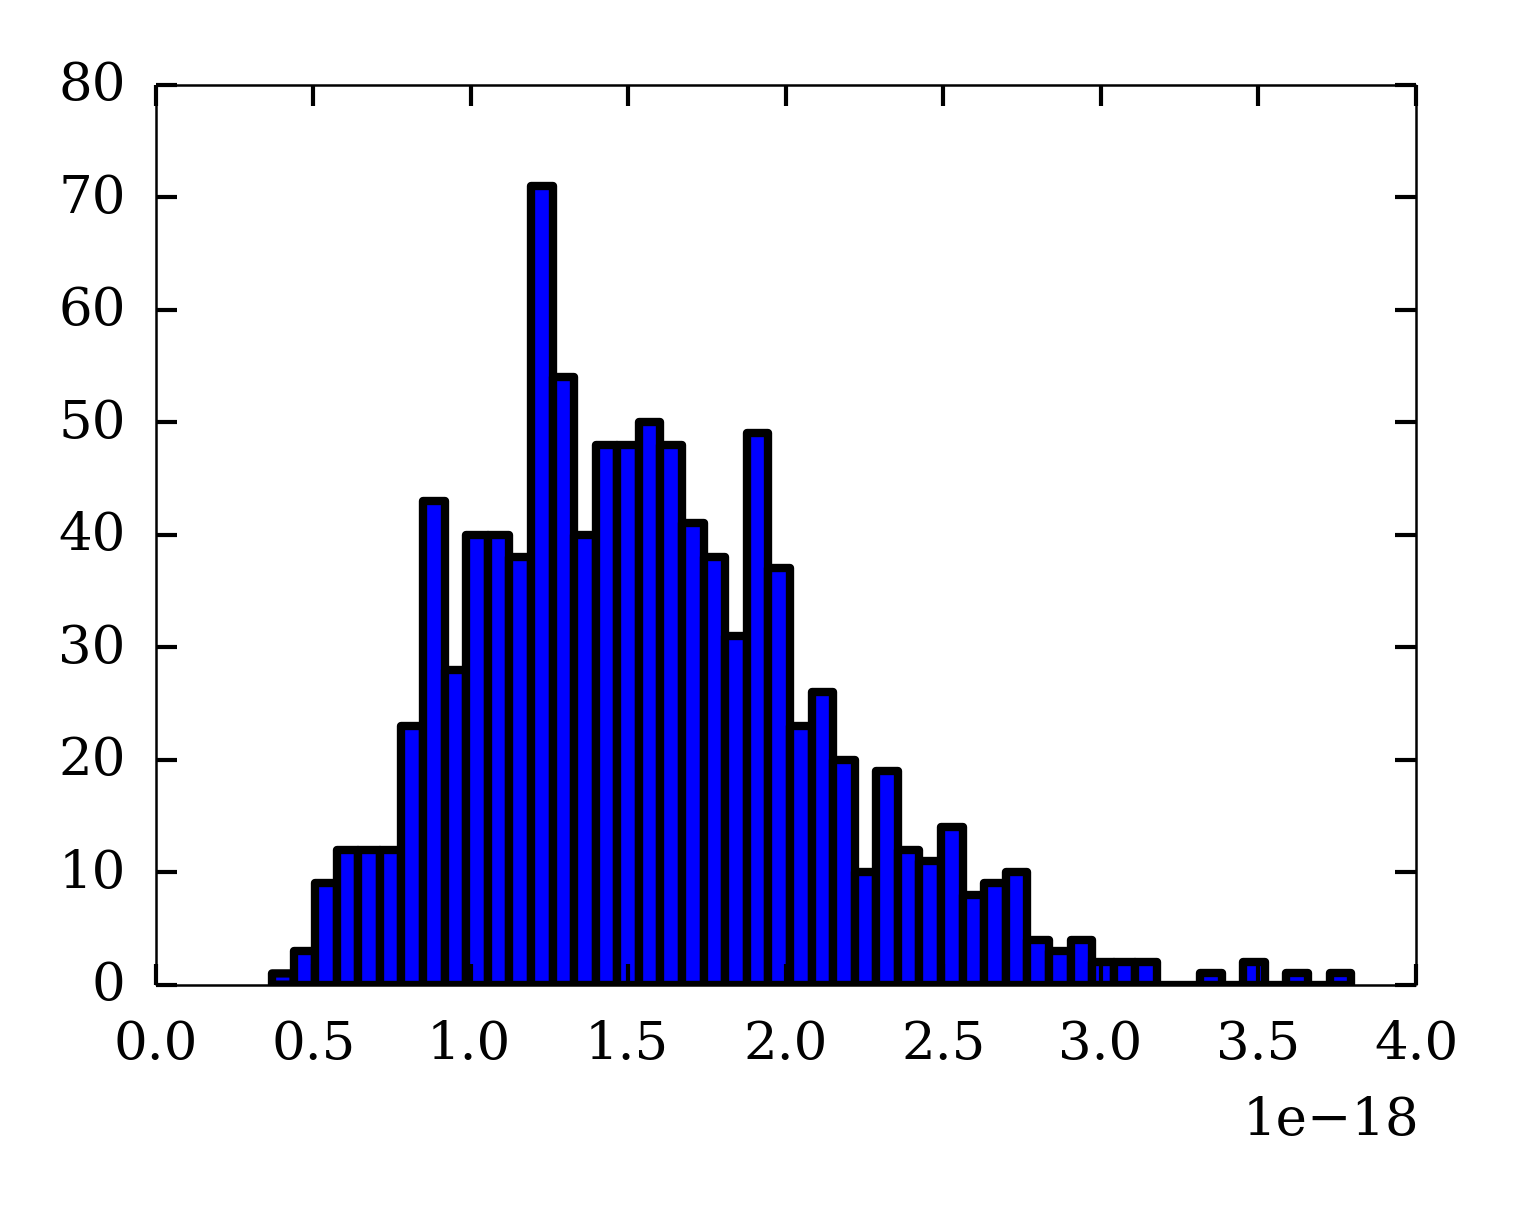

In [58]:
plt.hist(evals[0][-1000:], bins=50)

In [55]:
evals[0][-10000:].mean()

1.5262828757824597e-18

In [53]:
single.pca_eigvals[0][-20:].mean()

2.1911826685209282e-18

In [31]:
S_corrected = evals[1] + nf.A * (1 + (fr / nf.fc)**2)

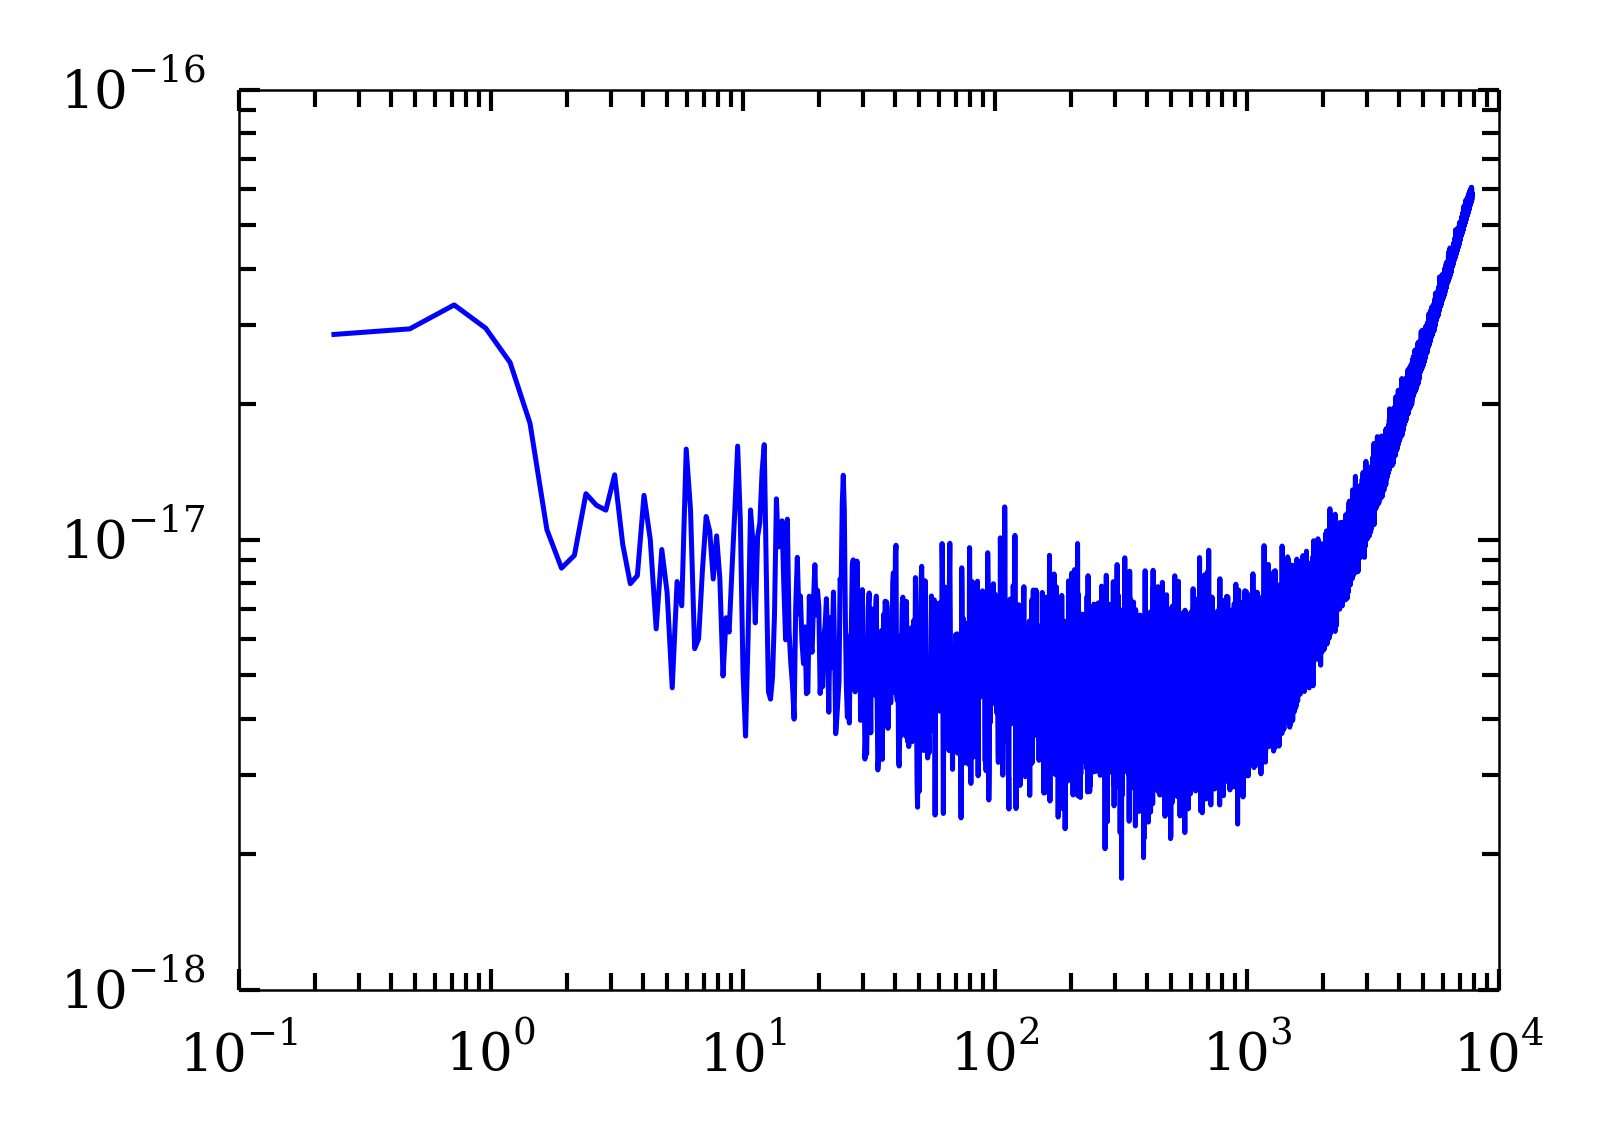

In [32]:
fig, ax = plt.subplots()
ax.plot(fr, S_corrected)

#ax.plot(fr, nf.A / (1 + (fr / nf.fc)**2) + nf.nw, '-k')
#ax.set_xlim(0.1, 3000)
#ax.set_ylim(2e-18, 2e-17)
ax.set_yscale('log')
ax.set_xscale('log');

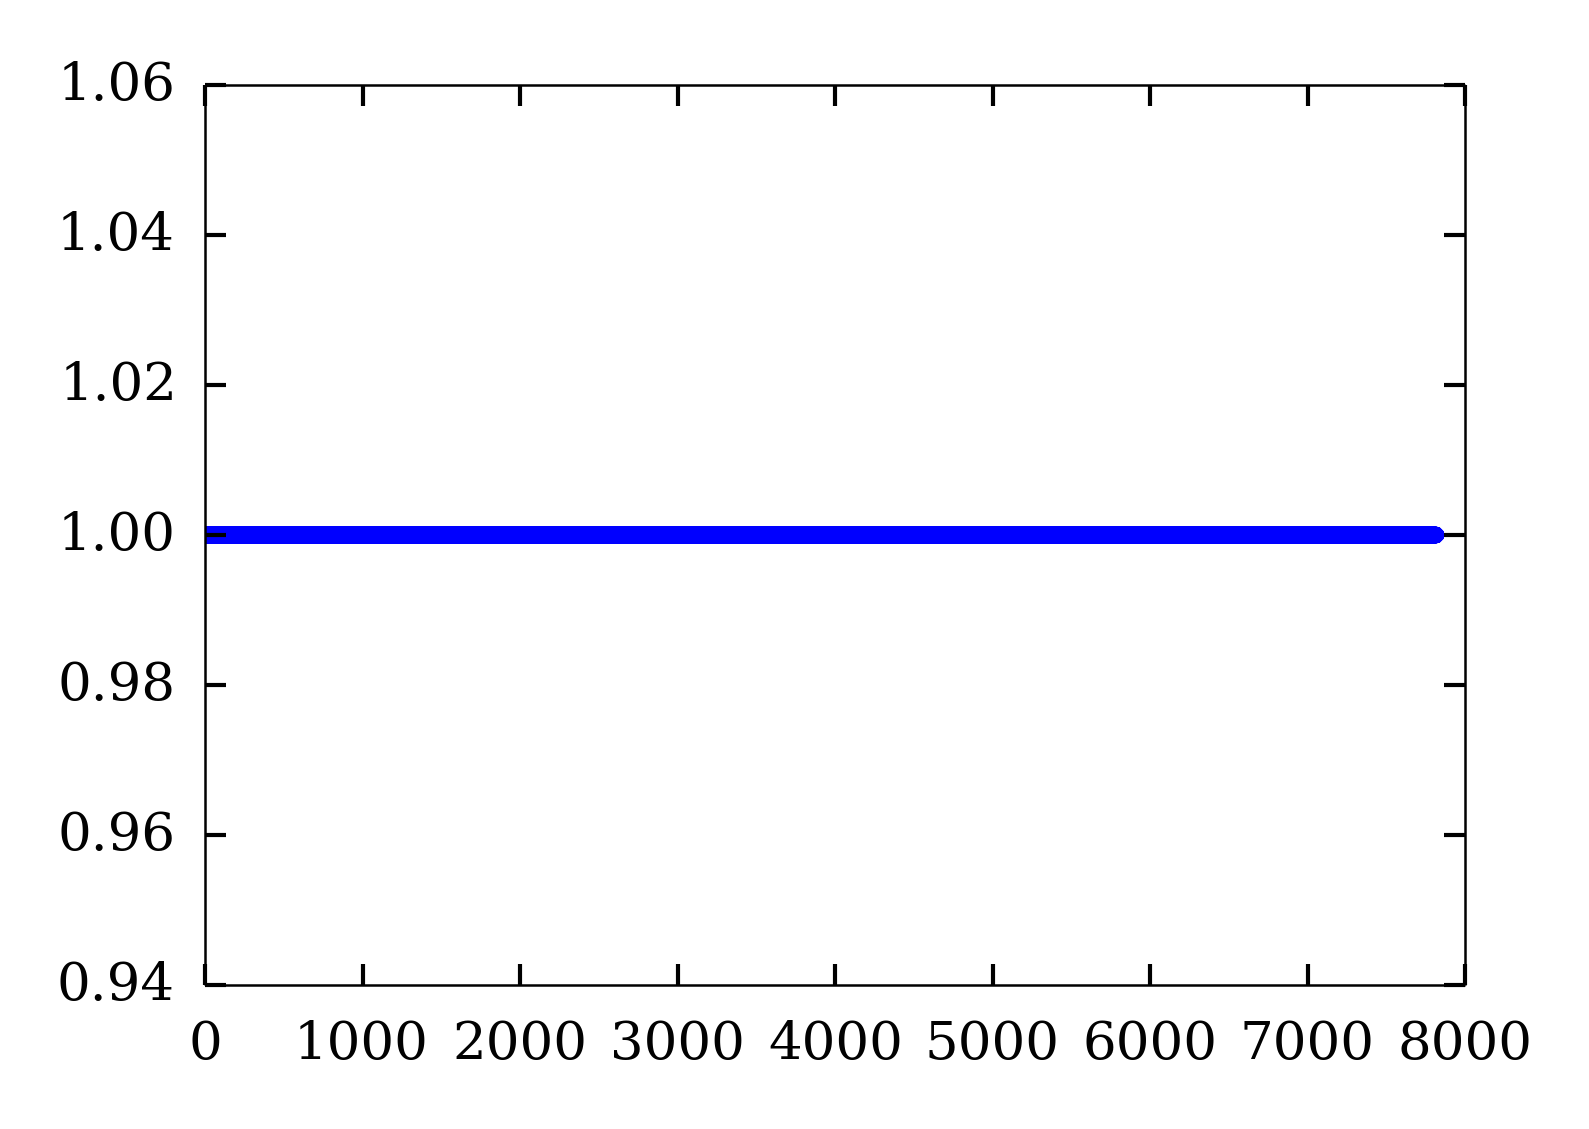

In [18]:
plt.plot(fr[1:], np.diff(fr) / fr[1], '.')

In [23]:
np.save('supplement/f.npy', fr)
np.save('supplement/S_corrected.npy', S_corrected)
np.save('supplement/S_full.npy', evals[1])

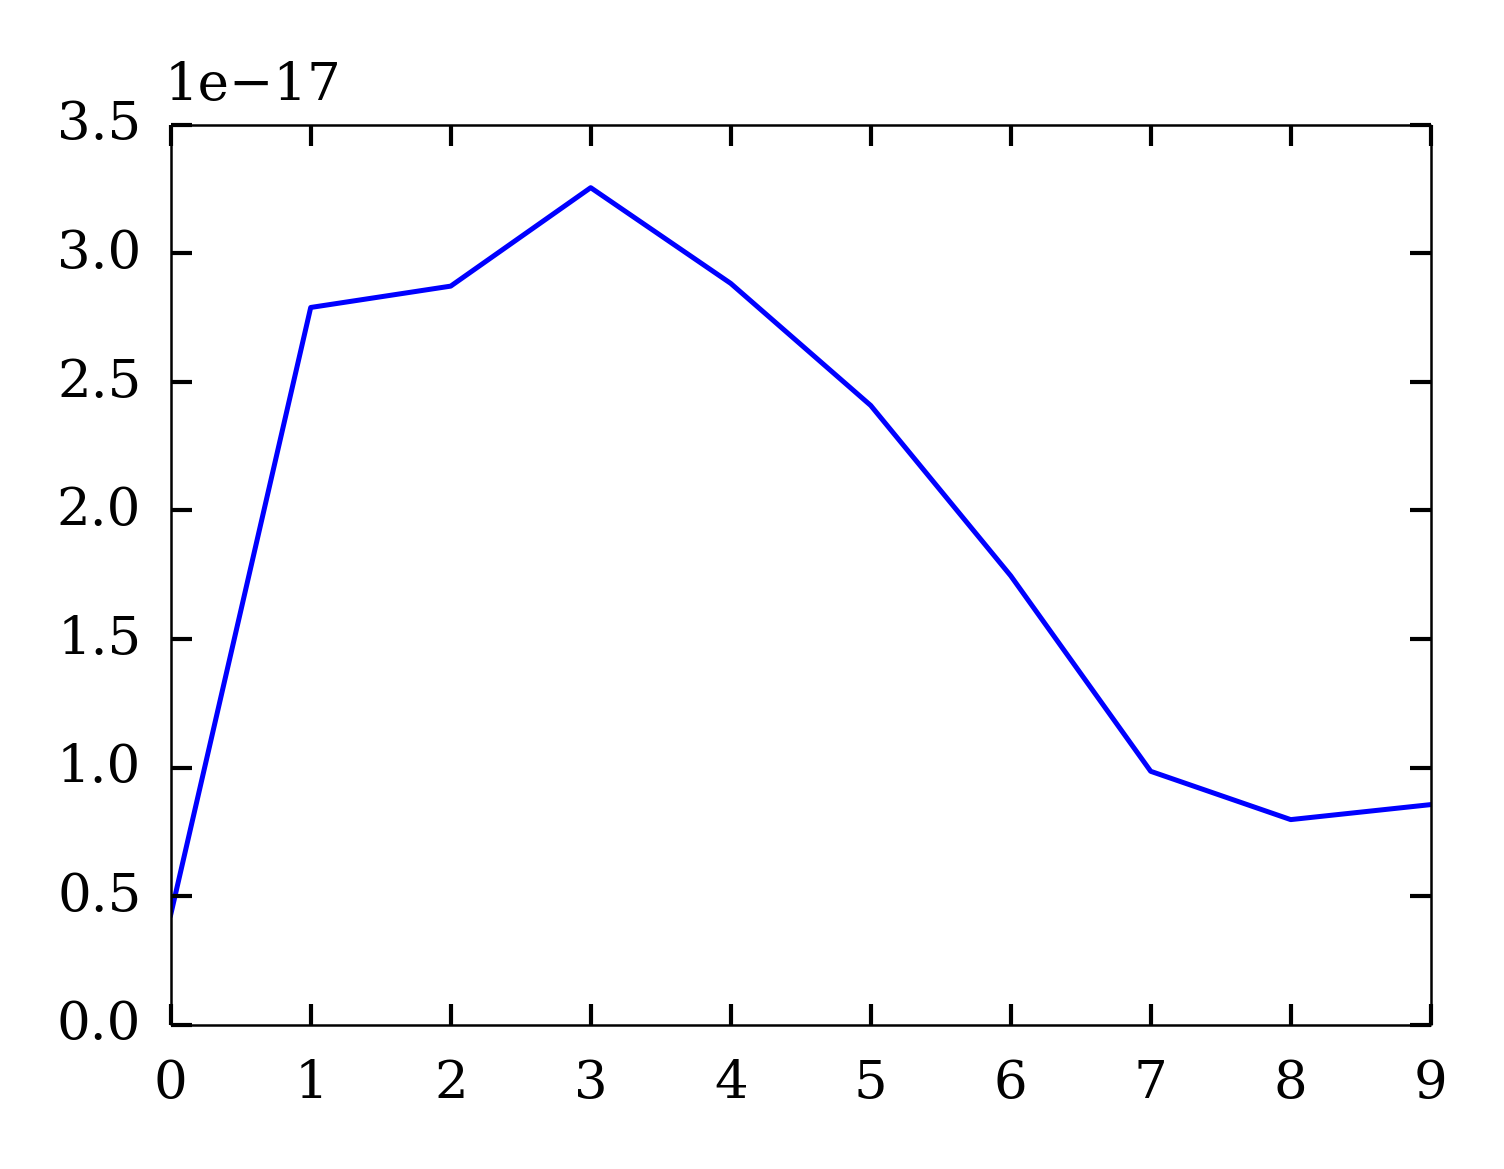

In [22]:
plt.plot(evals[1][:10])